In [2]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torch
!pip install sklearn
!pip install pandas
!pip install openpyxl # For reading Excel files

In [1]:
import numpy as np
import pandas as pd
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn as nn
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
import statsmodels.api as sm

## Data preprocessing

In [3]:
# Your provided file path
#file_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/labeled_data/Balanced_Labeled_sentence.xlsx'

# Load the Excel file
data = pd.read_csv('/content/drive/MyDrive/test/label/training_reviews.csv')

data

,Review Id,Published Date,Language,Location,Sentence Id,Sentence,1,2,3,4,5,6,7,8,9,10,11
0,642946946,2019/1/1,en,EVA Air,1,Seats selection taken .Watch out for their onl...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,642946946,2019/1/1,en,EVA Air,7,Excellent booking system so they can claim wha...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,643196125,2019/1/2,en,EVA Air,3,I flew Economy as it was a quick excursion.,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,643196125,2019/1/2,en,EVA Air,16,If you want the HELLO KITTY flight you must ch...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,643196125,2019/1/2,en,EVA Air,18,.Check-in and luggage process at Airport were ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4413,963575454,2024/8/6,ja,tigerair taiwan,2,The luggage to be checked in was 20 kg for one...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4414,964972641,2024/8/15,ja,tigerair taiwan,8,"Originally, this problem was an accident when ...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4415,971661772,2024/9/27,ja,tigerair taiwan,2,"I think the cabin is a little small, but it wa...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4416,971661772,2024/9/27,ja,tigerair taiwan,5,"It took a long time to leave, but I'm glad I w...",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
tokens = data['Sentence'].apply(lambda x: tokenizer.encode_plus(x, max_length=512, truncation=True, padding='max_length', return_tensors='pt'))

# Extract input IDs and attention masks from the tokens
input_ids = [token['input_ids'] for token in tokens]
attention_masks = [token['attention_mask'] for token in tokens]

# Convert lists to tensors
input_ids = torch.cat(input_ids)
attention_masks = torch.cat(attention_masks)
labels = torch.tensor(data.iloc[:, 6:].values.astype(np.float32))  #修改成6列後

# Split the data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 自行修改

In [15]:
import torch
torch.cuda.empty_cache()

In [16]:
# 選取 'Sentence' 作為文本，1~11 欄位作為標籤
texts = data['Sentence'].astype(str)  # 確保是字串格式
labels = data.iloc[:, 6:].astype(float)  # 6列之後是標籤

# 初始化 tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization
tokens = texts.apply(lambda x: tokenizer.encode_plus(
    x, max_length=512, truncation=True, padding='max_length', return_tensors='pt'))

# 轉換成張量
input_ids = torch.cat([token['input_ids'] for token in tokens])
attention_masks = torch.cat([token['attention_mask'] for token in tokens])
labels = torch.tensor(labels.values, dtype=torch.float32)  # 確保標籤是 float32

# 切分訓練集與測試集
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1, random_state=42)

# 設定 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化 BERT 模型（多標籤分類）
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=11)  # 11 個標籤
model = BertForSequenceClassification(config).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 4072 has 14.73 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 149.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:



# 設定 DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 4
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# 設定優化器與損失函數（多標籤分類應用 BCEWithLogitsLoss）
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = torch.nn.BCEWithLogitsLoss()  # 適用於多標籤分類

# 訓練 BERT
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch_input_ids, batch_input_mask, batch_labels = [b.to(device) for b in batch]
        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_input_mask)
        logits = outputs.logits

        loss = criterion(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}')

# 儲存訓練後的模型
model.save_pretrained("/content/drive/MyDrive/bert_airline_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_airline_model")
print("Model saved successfully!")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 96.12 MiB is free. Process 4072 has 14.64 GiB memory in use. Of the allocated memory 14.37 GiB is allocated by PyTorch, and 160.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Model configuration

In [9]:

class BertForMultiLabelRegression(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        # Replace the classifier with a new one for regression
        # We use a linear layer to output continuous values
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        # Apply the regression layer
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[6:]  # add hidden states and attention if they are here

        return outputs  # logits, (hidden_states), (attentions)

# Load the configuration from 'bert-base-uncased'
config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = data.shape[1] - 1  # Assuming the first column is text and the rest are labels

# Initialize the model
model = BertForMultiLabelRegression(config)


In [10]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.MSELoss()

## Training process

In [ ]:
# Check if a GPU is available and set PyTorch to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Then, make sure to move your model to the device
model.to(device)

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Convert the DataFrame to a TensorDataset
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)

# Create the DataLoaders
batch_size = 16  # You might need to adjust this depending on your GPU memory

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

# Training loop
epochs = 4  # The BERT authors recommend 2-4 epochs for fine-tuning

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================

    model.train()  # Put the model in training mode
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(batch_input_ids,
                        token_type_ids=None,
                        attention_mask=batch_input_mask)

        logits = outputs[0]

        # Calculate the loss
        loss = criterion(logits, batch_labels)
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Update parameters and take a step using the computed gradient
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print('Average training loss: {0:.2f}'.format(avg_train_loss))

    # ========================================
    #               Validation
    # ========================================
    model.eval()  # Put the model in evaluation mode

    # Repeat the above process for the validation data
    # Calculate metrics like RMSE here to evaluate performance

print("Training complete!")


RuntimeError: The size of tensor a (16) must match the size of tensor b (11) at non-singleton dimension 1

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np

# Put model in evaluation mode
model.eval()

# Track variables
predictions, true_labels = [], []

# Predict
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for overall metrics
predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)

# Calculate the Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(true_labels, predictions)
rmse = sqrt(mse)

# Calculate the coefficient of determination R^2
r2 = r2_score(true_labels, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Coefficient of Determination (R^2): {r2}')


Mean Squared Error (MSE): 0.05931556969881058
Root Mean Squared Error (RMSE): 0.24354787968448952
Coefficient of Determination (R^2): 0.49367381476158234


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define your thresholds for binarization here
# This is a simple example with a single threshold for all labels,
# but you might want to customize this per label based on your understanding of the data
thresholds = np.array([0.5] * true_labels.shape[1])

# Convert continuous predictions and true labels to binary using thresholds
binary_predictions = (predictions >= thresholds).astype(int)
binary_true_labels = (true_labels >= thresholds).astype(int)

label_names = ['Ingratiation', 'Intimidation', 'Org_promotion', 'Supplication', 'Exemplification']


# Function to plot confusion matrix with specific titles
def plot_confusion_matrix(cm, class_name):
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Modified loop to use specific dimension names
for i, label_name in enumerate(label_names):
    cm = confusion_matrix(binary_true_labels[:, i], binary_predictions[:, i])
    plot_confusion_matrix(cm, class_name=label_name)


In [ ]:
def predict(text, tokenizer, model, device):
    model.eval()
    tokens = tokenizer.encode_plus(text, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    predicted_labels = logits.squeeze().cpu().numpy()

    return predicted_labels

# Example usage
text = "The big challenge was finding a CTO, as Im a nontechnical founder but we have found that person now. Now, the big task is to build the MVP and fundraise to ensure that we have enough runway to bring the product to market and scale it  so that it can be of benefit to as many people as possible, and help us build a sustainable business that is working towards the greater good in the workplace."
predicted_labels = predict(text, tokenizer, model, device)
print(predicted_labels)

[-0.05811442  0.0629804  -0.05144737  1.0143414   0.05538667]


## Save the model

In [ ]:
model_save_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT'

# Make sure the path exists or create it
import os
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT/tokenizer_config.json',
 '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT/special_tokens_map.json',
 '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT/vocab.txt',
 '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT/added_tokens.json')

## Load the model

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
model_save_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT'

model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

In [ ]:
# Your provided file path
file_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/labeled_data/test.xlsx'

# Load the Excel file
test_data = pd.read_excel(file_path)

In [ ]:
# Check if a GPU is available and set PyTorch to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Then, make sure to move your model to the device
model.to(device)

Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Model evaluation

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report

# Load the model and tokenizer
model_save_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT'
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Load the testing data
file_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/labeled_data/generated_sentences_adjusted.xlsx'
test_data = pd.read_excel(file_path)

# Function to tokenize and prepare inputs
def preprocess_texts(texts):
    encoded_batch = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return encoded_batch

# Tokenize the texts
inputs = preprocess_texts(test_data['Text'].tolist())

# Prepare labels
labels = test_data[['INGRATIATION', 'INTIMIDATION', 'ORG_PROMOTION', 'SUPPLICATION', 'EXEMPLIFICATION']].values.argmax(axis=1)

# Move tensors to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
labels = torch.tensor(labels).to(device)

# Prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=-1)

# Evaluation
print(classification_report(labels.cpu(), predictions.cpu(), target_names=['ingratiation', 'intimidation', 'org_promotion', 'supplication', 'exemplification']))


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import pandas as pd
from sklearn.metrics import classification_report
import torch.nn.functional as F

# Load the model and tokenizer
model_save_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/BERT'
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Load the testing data
file_path = '/content/drive/MyDrive/My Research/My paper/Data resource/datasets/labeled_data/generated_sentences.xlsx'
test_data = pd.read_excel(file_path)

# Function to tokenize and prepare inputs
def preprocess_texts(texts):
    encoded_batch = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return encoded_batch

# Tokenize the texts
inputs = preprocess_texts(test_data['text'].tolist())

# Prepare labels
labels = test_data[['ingratiation', 'intimidation', 'org_promotion', 'supplication', 'exemplification']].values

# Move tensors to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
labels = torch.tensor(labels).to(device)

# Prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Apply sigmoid function to convert logits to probabilities
probs = torch.sigmoid(logits)

# Apply threshold
threshold = 0.5
predicted_labels = (probs > threshold).int()

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())
precision = precision_score(labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='samples')
recall = recall_score(labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='samples')
f1 = f1_score(labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='samples')

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


### Confusion matrix

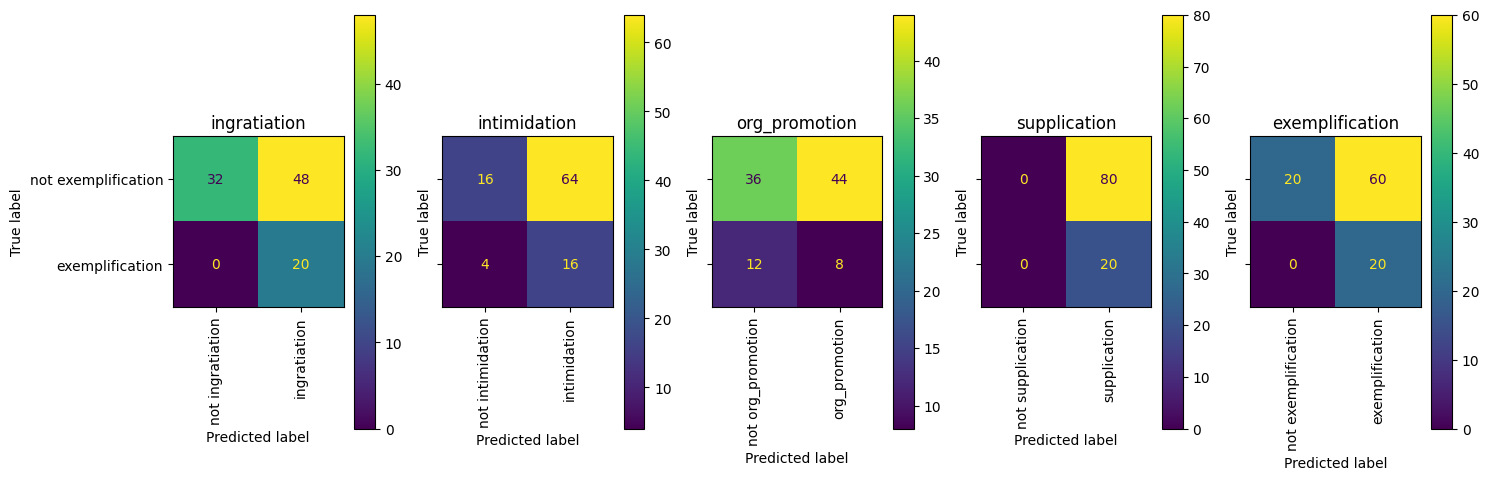

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# 检查是否已经是NumPy数组，如果不是则从Tensor转换
def ensure_numpy_array(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.cpu().numpy()  # 从PyTorch Tensor转换为NumPy数组
    return tensor  # 已经是NumPy数组

# 定义一个函数来绘制多标签的混淆矩阵
def plot_multilabel_confusion_matrix(y_true, y_pred, labels):
    # 绘制每个标签的混淆矩阵
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 5), sharey='row')
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'not {label}', label])
        disp.plot(ax=axes[i], xticks_rotation='vertical')
        axes[i].title.set_text(label)
    plt.tight_layout()
    plt.show()

# 假设labels_matrix和predicted_labels_matrix是从模型获得的，现在确保它们是NumPy数组
labels_matrix = ensure_numpy_array(labels)  # 确保labels是NumPy数组
predicted_labels_matrix = ensure_numpy_array(predicted_labels)  # 确保predicted_labels是NumPy数组

# 标签列表
labels_list = ['ingratiation', 'intimidation', 'org_promotion', 'supplication', 'exemplification']

# 调用函数，绘制混淆矩阵
plot_multilabel_confusion_matrix(labels_matrix, predicted_labels_matrix, labels_list)
